# This notebook demonstrates how to use kepler_kinematics to calculate stellar velocities

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import pymc3 as pm

import corner

import kepler_kinematics as kek

Let's load the Gaia-Kepler crossmatched catalog.

In [3]:
with fits.open("../../data/kepler_dr2_1arcsec.fits") as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")

In [4]:
gaia_rv = gaia.iloc[gaia.radial_velocity.values != 0.]

Select a star.

In [74]:
np.random.seed(1)
star_index = np.random.randint(0, len(gaia_rv))
print(star_index)
df = gaia_rv.iloc[star_index]
print(int(df.kepid))

29733
12218729


First, let's calculate the 3D velocities of the star using its radial velocity.

In [75]:
# for i, row in enumerate(df):
xyz, vxyz = kek.simple_calc_vxyz(df["ra"], df["dec"],
                                 1./df["parallax"],
                                 df["pmra"], df["pmdec"],
                                 df["radial_velocity"])

vx, vy, vz = vxyz
x, y, z = xyz
d = df["r_est"]

Now let's infer the 3D velocities of the star. First we'll create arrays of position, parallax, and proper motion.

In [76]:
pos = [float(df["ra"]), float(df["dec"]), float(df["parallax"])]
pos_err = [float(df["ra_error"]), float(df["dec_error"]),
           float(df["parallax_error"])]
proper = [float(df["pmra"]), float(df["pmdec"])]
proper_err = [float(df["pmra_error"]), float(df["pmdec_error"])]

Get the prior that's built-in for Kepler stars.

In [77]:
mu, cov = kek.get_prior()

Run the velocity inference code.

In [78]:
trace = kek.run_pymc3_model(pos, pos_err, proper, proper_err, mu, cov)

optimizing logp for variables: [vxyzD]


message: Optimization terminated successfully.
logp: -2177.6893532762156 -> -10.145461053861254


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vxyzD]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 23 seconds.


Pull out the results from the samples.

In [79]:
import arviz as az

az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
vxyzD[0],31.258,2.544,26.772,36.229,0.041,0.029,3922.0,3922.0,3937.0,2969.0,1.0
vxyzD[1],228.029,23.403,184.209,271.542,0.377,0.266,3862.0,3862.0,3898.0,2984.0,1.0
vxyzD[2],0.623,5.300,-9.503,10.151,0.085,0.085,3858.0,1966.0,3894.0,3089.0,1.0
vxyzD[3],-1.036,0.028,-1.091,-0.989,0.000,0.000,4199.0,4199.0,4200.0,3013.0,1.0
vxyz[0],31.258,2.544,26.772,36.229,0.041,0.029,3922.0,3922.0,3937.0,2969.0,1.0
vxyz[1],228.029,23.403,184.209,271.542,0.377,0.266,3862.0,3862.0,3898.0,2984.0,1.0
vxyz[2],0.623,5.300,-9.503,10.151,0.085,0.085,3858.0,1966.0,3894.0,3089.0,1.0
log_D,-1.036,0.028,-1.091,-0.989,0.000,0.000,4199.0,4199.0,4200.0,3013.0,1.0
D,0.355,0.010,0.336,0.372,0.000,0.000,4186.0,4170.0,4200.0,3013.0,1.0
xyz[0],-8.086,0.001,-8.088,-8.084,0.000,0.000,4186.0,4186.0,4200.0,3013.0,1.0


In [80]:
# trace.posterior.to_dataframe()
print(np.median(trace.posterior["D"].values))
print(np.median(trace.posterior["vxyz"].values, axis=(0, 1)))

0.354629642899027
[ 31.25734744 227.8835832    0.55436242]


In [81]:
print(np.shape(trace.posterior["vxyzD"].values))
vsamples = np.reshape(trace.posterior["vxyzD"].values, (4000, 4))
print(np.shape(vsamples))

(4, 1000, 4)
(4000, 4)


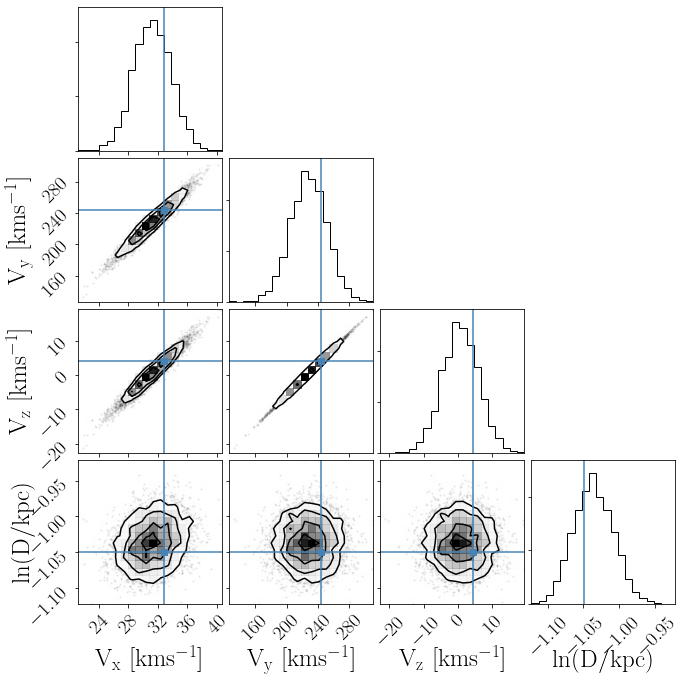

In [82]:
labels = ["$\mathrm{V_x~[kms^{-1}]}$", "$\mathrm{V_y~[kms^{-1}]}$", "$\mathrm{V_z~[kms^{-1}]}$", "$\mathrm{\ln(D/kpc)}$"]
fig = corner.corner(vsamples, labels=labels, truths=[vx.value, vy.value, vz.value, np.log(d*1e-3)], dpi=200);
# plt.title(f"KIC {format(int(df.kepid))}")
plt.savefig("../plots/posterior")
plt.savefig("../paper/posterior.pdf")

In [10]:
flat_samples = pm.trace_to_dataframe(trace)

params_inferred = np.median(flat_samples, axis=0)
upper = np.percentile(flat_samples, 84, axis=0)
lower = np.percentile(flat_samples, 16, axis=0)
errp = upper - params_inferred
errm = params_inferred - lower
std = np.std(flat_samples, axis=0)

results = pd.DataFrame(dict({"kepid": df["kepid"],
                             "vx": params_inferred[0], "vx_errp": errp[0], "vx_errm": errm[0], "vx_err": std[0],
                             "vy": params_inferred[1], "vy_errp": errp[1], "vy_errm": errm[1], "vy_err": std[1],
                             "vz": params_inferred[2], "vz_errp": errp[2], "vz_errm": errm[2], "vz_err": std[2],
                             "lndistance": params_inferred[3], "lndistance_errp": errp[3],
                             "lndistance_errm": errm[3], "lndistance_err": std[3]
                            }), index=[0])

In [11]:
print(f"{vx:.1f}, {float(results.vx.values):.1f} +/- {float(results.vx_err.values):.1f} km / s")
print(f"{vy:.1f}, {float(results.vy.values):.1f} +/- {float(results.vy_err.values):.1f} km / s")
print(f"{vz:.1f}, {float(results.vz.values):.1f} +/- {float(results.vz_err.values):.1f} km / s")

50.4 km / s, 52.8 +/- 8.7 km / s
215.2 km / s, 220.7 +/- 22.7 km / s
-0.3 km / s, 0.7 +/- 4.2 km / s


In [12]:
print(f"{vx:.1f}, {float(results.vx.values):.1f} +/- {float(results.vx_err.values):.1f} km / s")
print(f"{vy:.1f}, {float(results.vy.values):.1f} +/- {float(results.vy_err.values):.1f} km / s")
print(f"{vz:.1f}, {float(results.vz.values):.1f} +/- {float(results.vz_err.values):.1f} km / s")

50.4 km / s, 52.8 +/- 8.7 km / s
215.2 km / s, 220.7 +/- 22.7 km / s
-0.3 km / s, 0.7 +/- 4.2 km / s
